In [1]:
#import libraries
import numpy as np
from ase.io import read, write
from ase import Atoms
import os
os.makedirs('config', exist_ok=True)
import torch

In [2]:
#importing the full data (this is in case I have like the whole data in one file)
db = read('251017_training_data.xyz', ':')

In [3]:
#splitting the data into the training and test sets
write('train_01.xyz', db[:250])
write('test_01.xyz', db[250:])

In [4]:
%%writefile config_new_model.yml
model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
name: "model01"
train_file: "train_01.xyz"
valid_fraction: 0.01
test_file: "test_01.xyz"
energy_key: "energy"
forces_key: "forces"
batch_size: 32
max_num_epochs: 100
device: cpu
seed: 123

Overwriting config_new_model.yml


In [5]:
#Perform training
import warnings
warnings.filterwarnings('ignore')
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging

#defining the training function
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ['program', '--config', config_file_path]
    mace_run_train_main()

#calling the function
train_mace('config_new_model.yml') #aca va el nombre del yml file 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
2025-10-20 01:40:17.208 INFO: ===========VERIFYING SETTINGS===========
2025-10-20 01:40:17.209 INFO: MACE version: 0.3.14
2025-10-20 01:40:17.210 INFO: Using CPU
2025-10-20 01:40:17.286 INFO: ===========LOADING INPUT DATA===========
2025-10-20 01:40:17.287 INFO: Using heads: ['Default']
2025-10-20 01:40:17.287 INFO: Using the key specifications to parse data:
2025-10-20 01:40:17.287 INFO: Default: KeySpecification(info_keys={'energy': 'energy', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 'elec_temp', 'total_charge': 'total_charge', 'polarizability': 'polarizability', 'total_spin': 'total_spin'}, arrays_keys={'forces': 'forces', 'charges': 'REF_charges'})
2025-10-20 01:40:17.288 INFO: =============    Processing head Default     ===========
2025-10-20 01:40:17.333 WARNING: Since ASE version 3.23.0b1, using energy_key 'energy' is no

In [6]:
#checking the training and validation loss
import json
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
#reading the information on the results file
results = 'results/model01_run-123_train.txt' #reading the file where the training results is stores
data = [] #where the data from the 'results' file will be stored
with open(results, 'r') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

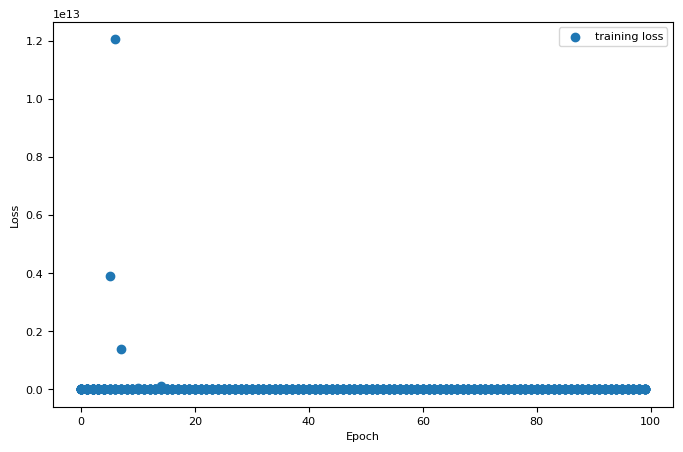

In [12]:
#saving the data in a dataframe to be able to work with it in an easier way
df = pd.DataFrame(data)
#separating the training and validation results
train_df = df[df['mode']=='opt'].copy()
val_df = df[df['mode']=='eval'].copy()
#here we take the na values of the epocs that might appear by using the ffill function which fills the na values by propagating the last vaid observation to next valid 
train_df['epoch'] = train_df['epoch'].ffill()
val_df['epoch'] = val_df['epoch'].ffill()
#plotting the 
plt.figure(figsize=(8,5))
plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
#plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

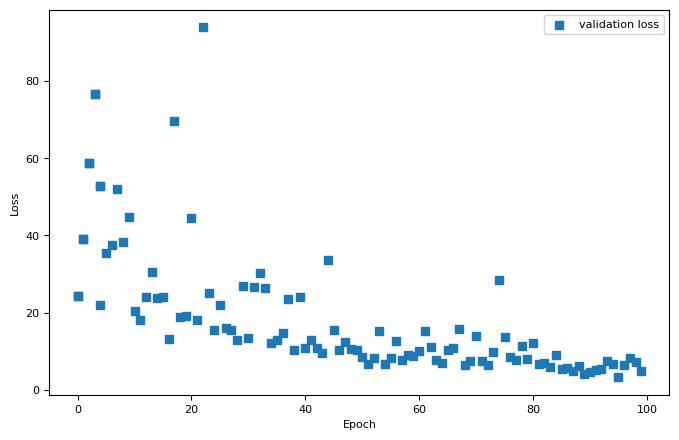

In [11]:
plt.figure(figsize=(8,5))
#plt.scatter(train_df['epoch'],train_df['loss'], label='training loss', marker='o')
plt.scatter(val_df['epoch'],val_df['loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [9]:
#once the training is done, then a calculation can be performed using ase
from ase.io import read
from mace.calculators import MACECalculator

#loading the model
calculator = MACECalculator(model_paths='model01.model', device='cpu')
#read the configurations from where we want to calculate
### I set here the training data, but we could also calculate it on different data to see how it actually performs on new data
configs = read('test_01.xyz', ':')

#set a list to store the information
results = []
# read the results
for i, atoms in enumerate(configs):
    atoms.set_calculator(calculator)
    energy = atoms.get_potential_energy()
    forces = atoms.get_forces()
    #max_force = abs(forces).max()  # max absolute force
    #mean_force = abs(forces).mean()  # mean absolute force
    # Add to list
    results.append({
        "config_id": i,
        "energy (eV)": energy,
    #    "max_force (eV/Å)": max_force,
    #    "mean_force (eV/Å)": mean_force,
        "num_atoms": len(atoms)
    })
# Create dataframe
df = pd.DataFrame(results)
df

2025-10-20 01:46:17.247 INFO: Using CPU
Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.


,config_id,energy (eV),num_atoms
0,0,-40.499700,10
1,1,-37.725455,10
2,2,-49.702329,10
3,3,-40.735976,10
4,4,-35.743671,10
...,...,...,...
398,398,-82.852763,15
399,399,-81.016542,15
400,400,-81.565562,15
401,401,-81.907784,15


In [14]:
!git status
!git add .
!git commit -m "new update"
!git push

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   training_notebook.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
[main 56ac75d] new update
 1 file changed, 271 insertions(+), 128 deletions(-)
Enumerating objects: 31, done.
Counting objects: 100% (31/31), done.
Delta compression using up to 20 threads
Compressing objects: 100% (18/18), done.
error: RPC failed; HTTP 400 curl 22 The requested URL returned error: 400
send-pack: unexpected disconnect while reading sideband packet
Writing objects: 100% (18/18), 2.33 MiB | 3.22 MiB/s, done.
Total 18 (delta 9), reused 0 (delta 0), pack-reused 0
fatal: the remote end hung up unexpectedly
Everything up-to-date
